## Sinkhorn embeddings

In [1]:
import numpy as np
import torch
from helper import vec_sinkhorn_divergence
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import pandas as pd
from sklearn.cluster import DBSCAN
from joblib import Parallel, delayed

In [2]:
# Set this variable to 1 if you want to save your plots
save_figs = 0

### Equilateral dimension

In [3]:
def experiment_1(j):
    res_ = {}
    for d in range(3, 7):
        res_[d] = []
        for n in range(2*(d+1), 2*(d+5)):

            # Build equidistant points
            distances = np.ones((n, n))

            # Variables
            rng = np.random.RandomState(j)
            x = rng.randn(n, d, m)
            x = torch.tensor(x, requires_grad=True, dtype=torch.float64)

            # Take the strict upper matrix as the objective
            objective = torch.tensor(distances + np.eye(n))

            # ADAM optimizer
            optimizer = torch.optim.Adam([x], lr = 0.1)

            # Training loop
            for i in range(n_steps):
                cur_step = i
                optimizer.zero_grad()
                with torch.autograd.detect_anomaly():
                    res = torch.triu(vec_sinkhorn_divergence(x, *params), diagonal=1)
                    loss = torch.sum(torch.triu((res-objective)/objective, 
                                                diagonal=1)**2)/(n*(n-1)/2)
                    loss.backward()
                    optimizer.step()

            loss = torch.sum(torch.triu((res-objective)/objective, 
                                                    diagonal=1)**2)/(n*(n-1)/2)
            res_[d].append(loss.detach().numpy())
    return res_

In [6]:
# Set this variable to 1 if you want to reproduce the expriment on your local machine
reproduce_experiment = 0

# Number of simulations
N = 20

if reproduce_experiment:

    # Set the sinkorn div algo 
    n_iter = 5
    p = 1
    reg = 0.1

    # Compute the list of params
    params = [n_iter, p, reg]

    # Ground space dimension
    m = 2

    # Number of training steps
    n_steps = 500
    
    # Parallel estimations of Mean Quadratic Distorsion
    l = Parallel(n_jobs=-1)(delayed(experiment_1)(i) for i in range(N))
    
    # Format and save data
    a = pd.DataFrame(l).values
    m = np.zeros((N, 4, 8))
    for i in range(N):
        for j in range(4):
            l_ = a[i][j]
            for k, x in enumerate(l_):
                m[i, j, k] = np.log(x)
    np.save('Data/exp_1', m)
    
else:
    m = np.load('Data/exp_1.npy')

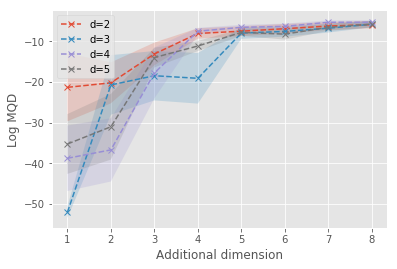

In [7]:
# Plot the MQD for several additional dimensions
for i in range(4):
    x = np.arange(1, 9)
    y = np.mean(m[i, :], axis=0)
    std = np.std(m[i, :], axis=0)
    plt.plot(x, y, '--x', label='d=' + str(i+2))
    plt.fill_between(x, y-std*1.96/(N)**0.5, y+std*1.96/(N)**0.5, alpha=0.2)
    
plt.xlabel('Additional dimension')
plt.ylabel('Log MQD')
plt.legend()

if save_figs:
    plt.savefig('Plots/experiment_1')

#### Visualize Wasserstein equidistant points

In [8]:
# Build equidistant points
n = 10
distances = np.ones((n, n))

In [9]:
# Set the sinkorn div algo 
n_iter = 5
p = 1
reg = 0.1

# Compute the list of params
params = [n_iter, p, reg]

# Ground space dimension
m = 2

# Number of dirac masses
d = 3

# Variables
np.random.seed(666)
x = np.random.randn(n, d, m)
x = torch.tensor(x, requires_grad=True, dtype=torch.float64)

# Take the strict upper matrix as the objective
objective = torch.tensor(distances + np.eye(n))

# Number of training steps
n_steps = 500

# Set current step to 0
cur_step = 0

In [10]:
# ADAM optimizer
optimizer = torch.optim.Adam([x], lr = 0.1)

In [11]:
# Training loop
for i in range(cur_step, n_steps):
    cur_step = i
    try:
        optimizer.zero_grad()
        with torch.autograd.detect_anomaly():
            res = torch.triu(vec_sinkhorn_divergence(x, *params), diagonal=1)
            loss = torch.sum(torch.triu((res-objective)/objective, diagonal=1)**2)/(n*(n-1)/2)
            if cur_step%10 == 0:
                print('Loss at step ' + str(cur_step) + ': ' + str(loss.detach().numpy()))
            loss.backward()
            optimizer.step()
    except KeyboardInterrupt:
        print('Training interupted')
        break
        

Loss at step 0: 1.2426363717341127
Loss at step 10: 0.09753894164543371
Loss at step 20: 0.050010207046439034
Loss at step 30: 0.025450048493265074
Loss at step 40: 0.013457357245236569
Loss at step 50: 0.006873112611132667
Loss at step 60: 0.0033464554861873464
Loss at step 70: 0.0014528922084830389
Loss at step 80: 0.0006171332426564524
Loss at step 90: 0.00031961724798638876
Loss at step 100: 0.00018135506653786977
Loss at step 110: 0.00010690629837392004
Loss at step 120: 7.364743583735799e-05
Loss at step 130: 5.075495915863323e-05
Loss at step 140: 3.482743710573981e-05
Loss at step 150: 2.4528998194806597e-05
Loss at step 160: 1.7302997647750014e-05
Loss at step 170: 1.2273446915080517e-05
Loss at step 180: 8.81249127613916e-06
Loss at step 190: 6.462341321678454e-06
Loss at step 200: 4.86325145988555e-06
Loss at step 210: 3.7540730715396456e-06
Loss at step 220: 2.9602874265671675e-06
Loss at step 230: 2.375473346469508e-06
Loss at step 240: 1.933228868306089e-06
Loss at step 2

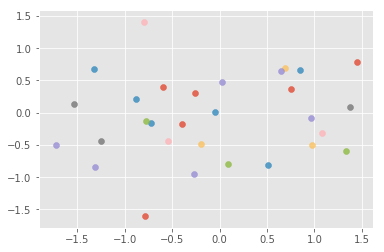

In [12]:
# Scatter all distributions
for i in range(n):
    plt.scatter(x.detach().numpy()[i, :, 0], x.detach().numpy()[i, :, 1], alpha=0.8)

### Weekly Sales Embedding

In [13]:
# Load the precomputed dynamic time wrapping distances
distances = np.load('Data/distances_dtw.npy')
idx = np.load('Data/idx_dtw.npy').astype(int)
n = len(idx)
print(str(n) + ' time series to embed.')

# Load the time corresponding series
df = pd.read_csv('Data/Sales_Transactions_Dataset_Weekly.csv')
data = df.iloc[:, 1:53].values[idx, :]

40 time series to embed.


In [14]:
# Peform hierachical clustering
estimator = DBSCAN(metric='precomputed', n_jobs=-1)
labels = estimator.fit_predict(distances)
print('DBSCAN found ' + str(len(np.unique(labels))) + ' different clusters in the time series.')


DBSCAN found 2 different clusters in the time series.


In [15]:
# Extract indexes
label_0 = np.where(labels==0)[0]
label_1 = np.where(labels==-1)[0]
print('Number of time series in cluster 0: ' + str(len(label_0)))
print('Number of time series in cluster 1: ' + str(len(label_1)))

Number of time series in cluster 0: 11
Number of time series in cluster 1: 29


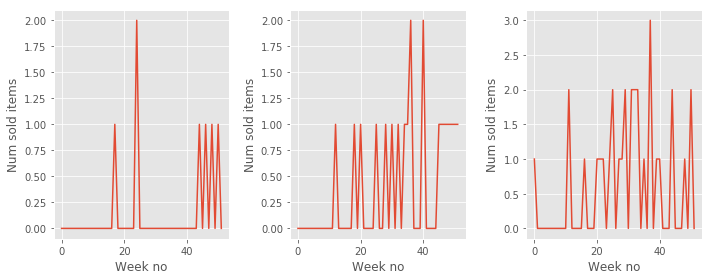

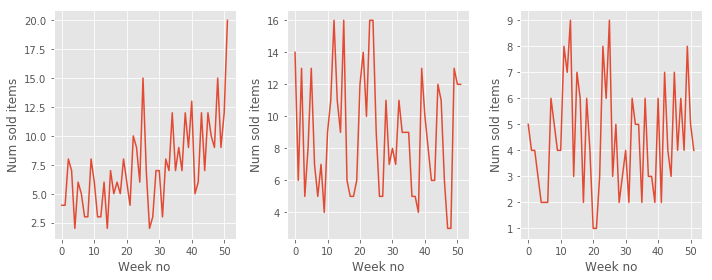

In [16]:
# Visualize the 2 different types of time series

# Random samples of clusters
np.random.seed(666)
sample_0 = np.random.choice(label_0, size=3, replace=False)
np.random.seed(666)
sample_1 = np.random.choice(label_1, size=3, replace=False)

# Plot type 0
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xlabel('Week no')
    plt.ylabel('Num sold items')
    plt.plot(data[sample_0[i]])
plt.tight_layout()
if save_figs:
    plt.savefig('Plots/Cluster_0')

# Plot type -1
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xlabel('Week no')
    plt.ylabel('Num sold items')
    plt.plot(data[sample_1[i]])
plt.tight_layout()
if save_figs:
    plt.savefig('Plots/Cluster_1')

In [17]:
# Set the sinkorn div algo 
n_iter = 3
p = 1
reg = 0.1

# Compute the list of params
params = [n_iter, p, reg]

# Ground space dimension
m = 2

# Number of dirac masses
d = 30

# Variables
np.random.seed(666)
x = np.random.randn(n, d, m)
x = torch.tensor(x, requires_grad=True, dtype=torch.float64)

# Take the strict upper matrix as the objective
objective = torch.tensor(distances + np.eye(n))

# Number of training steps
n_steps = 500

# Set current step to 0
cur_step = 0

In [18]:
# ADAM optimizer
optimizer = torch.optim.Adam([x], lr = 0.3)

In [20]:
# Set this variable to 1 if you want to train the model
perform_training = 0

if perform_training:
# Training loop
    for i in range(cur_step, n_steps):
        cur_step = i
        try:
            optimizer.zero_grad()
            with torch.autograd.detect_anomaly():
                res = torch.triu(vec_sinkhorn_divergence(x, *params), diagonal=1)
                loss = torch.sum(torch.triu((res-objective)/objective, diagonal=1)**2)/(n*(n-1)/2)
                if cur_step%10 == 0:
                    print('Loss at step ' + str(cur_step) + ': ' + str(loss.detach().numpy()))
                loss.backward()
                optimizer.step()
        except KeyboardInterrupt:
            print('Training interupted')
            break
        if cur_step == n_steps - 1:
            print('Saving the embedding')
            l = [x[i, :, :].detach().numpy() for i in range(n)]
            x = np.array(l)
            np.save('Data/embeddings_dtw', x)
else:
    x = np.load('Data/embeddings_dtw.npy')
    

In [21]:
# Split the embeddings accordings to the 2 clusters
x_0 = np.concatenate(np.squeeze(x[label_0]))
x_1 = np.concatenate(np.squeeze(x[label_1]))

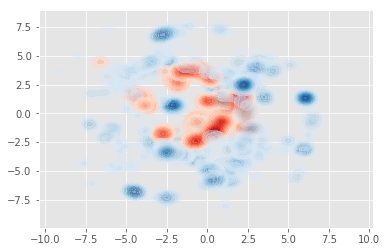

In [22]:
# Plot all the distributions according to their label
for i in range(n):
    if labels[i] == 0:
        sns.kdeplot(x[i, :, 0], x[i, :, 1],
        cmap="Reds", shade=True, shade_lowest=False, bw=0.4, alpha=0.6)
    else:
        sns.kdeplot(x[i, :, 0], x[i, :, 1],
        cmap="Blues", shade=True, shade_lowest=False, bw=0.4, alpha=0.4)
if save_figs:
    plt.savefig('Plots/mult_emb')
        

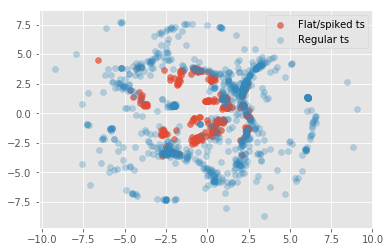

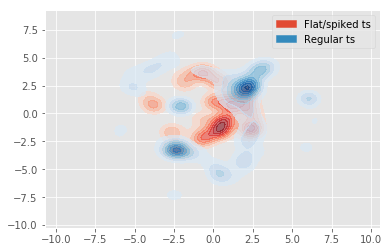

In [23]:
# Plot the merged distributions

# Raw diracs
plt.figure()
plt.scatter(x_0[:, 0], x_0[:, 1], alpha=0.7, label='Flat/spiked ts')
plt.scatter(x_1[:, 0], x_1[:, 1], alpha=0.3, label='Regular ts')
plt.legend()
if save_figs:
    plt.savefig('Plots/scatter_merged')

# Smoothed distributions
plt.figure()
sns.kdeplot(x_0[:, 0], x_0[:, 1],
                cmap="Reds", shade=True, shade_lowest=False, bw=0.5, alpha=0.6, 
           label='Flat/spiked ts')
sns.kdeplot(x_1[:, 0], x_1[:, 1],
                cmap="Blues", shade=True, shade_lowest=False, bw=0.5, alpha=0.7, 
            label='Regular ts')
plt.legend()
if save_figs:
    plt.savefig('Plots/smoothed_merged')